# **Prediction of Players Performance (GameScore)**

We would like to make use of machine learning to predict a player's peformance for an upcoming game by making use of data such as his average stats and his team's average stats over the past 10 games that they played. 

We hope that with an accurate model, the Houston Rockets would be able to make use of this to predict players who will perform well in upcoming games, thus improving their performance as a team in each game and improving their ranking in the league

In [620]:
# Import necessary packages

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import neighbors
from sklearn.neural_network import MLPClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from operator import itemgetter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from google.colab import drive

from sklearn import metrics


from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, RandomizedSearchCV

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier


In [621]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Read Data and Create Combined datasets**


*   combined_indiv: Eric Gordon's Game by Game score for each Season from 2016-2022

*   combined_indiv_21: Eric Gordon's Game by Game score for each Season from 2016-2021

*   combined_team: Houston Rocket's Game by Game score for each Season from 2016-2022

*   combined_indiv_21: Houston Rocket's Game by Game score for each Season from 2016-2021

In [622]:
path = '/content/drive/My Drive/BT4222/Eric_Gordon.xlsx'
eric_gordon = pd.ExcelFile(path)
eric_gordon1617 = pd.read_excel(eric_gordon, 'Eric Gordon 1617')
eric_gordon1718 = pd.read_excel(eric_gordon, 'Eric Gordon 1718')
eric_gordon1819 = pd.read_excel(eric_gordon, 'Eric Gordon 1819')
eric_gordon1920 = pd.read_excel(eric_gordon, 'Eric Gordon 1920')
eric_gordon2021 = pd.read_excel(eric_gordon, 'Eric Gordon 2021')
eric_gordon2122 = pd.read_excel(eric_gordon, 'Eric Gordon 2122')
hou1617 = pd.read_excel(eric_gordon, 'HOU 1617')
hou1718 = pd.read_excel(eric_gordon, 'HOU 1718')
hou1819 = pd.read_excel(eric_gordon, 'HOU 1819')
hou1920 = pd.read_excel(eric_gordon, 'HOU 1920')
hou2021 = pd.read_excel(eric_gordon, 'HOU 2021')
hou2122 = pd.read_excel(eric_gordon, 'HOU 2122')

combined_indiv = pd.concat([eric_gordon1617, eric_gordon1718, eric_gordon1819, eric_gordon1920, eric_gordon2021, eric_gordon2122])

combined_indiv_21 = pd.concat([eric_gordon1617, eric_gordon1718, eric_gordon1819, eric_gordon1920, eric_gordon2021])

combined_team = pd.concat([hou1617, hou1718, hou1819, hou1920, hou2021, hou2122])

combined_team_21 = pd.concat([hou1617, hou1718, hou1819, hou1920, hou2021])


In [623]:
combined_indiv
hou1617.head()

,Rk,G,Date,Unnamed: 3,Opp,W/L,Tm,Opp.1,FG,FGA,...,FT.1,FTA.1,FT%.1,ORB.1,TRB.1,AST.1,STL.1,BLK.1,TOV.1,PF.1
0,1.0,1.0,2016-10-26,@,LAL,L,114.0,120.0,44.0,86.0,...,18.0,22.0,0.818,11.0,39.0,21.0,10.0,4.0,15.0,24.0
1,2.0,2.0,2016-10-28,@,DAL,W,106.0,98.0,33.0,70.0,...,20.0,24.0,0.833,6.0,34.0,13.0,11.0,2.0,9.0,21.0
2,3.0,3.0,2016-10-30,NaN,DAL,W,93.0,92.0,34.0,81.0,...,17.0,20.0,0.850,13.0,43.0,17.0,8.0,3.0,9.0,17.0
3,4.0,4.0,2016-11-01,@,CLE,L,120.0,128.0,43.0,90.0,...,26.0,31.0,0.839,12.0,46.0,22.0,4.0,2.0,11.0,21.0
4,5.0,5.0,2016-11-02,@,NYK,W,118.0,99.0,42.0,89.0,...,17.0,25.0,0.680,7.0,34.0,18.0,10.0,6.0,16.0,22.0


**Create a Function to read and average player and team stats from last n games**


Output: combined data frame with average team and player scores from last n games

In [624]:
  #from player sheet, find average of all scores for last n games
  #from team sheet, find average of all scores for last n games


#given a team data, player data and a gamedate, this method will return dataframe containing average team and indiv stats over the previous n games

def get_avg_stats_last_n_games(player, game_date, season_team_stats, n) :
    prev_game_df = player[player['Date'] < game_date].sort_values(by = 'Date').tail(n)
    prev_team_df = season_team_stats[season_team_stats['Date'] < game_date].sort_values(by = 'Date').tail(n)

    team_df = prev_team_df.iloc[:,range(6, 24)].mean().to_frame().transpose()
  
    indiv_df = prev_game_df.iloc[:, range(10, 28)].mean().to_frame().transpose()

    result = pd.concat([team_df, indiv_df], axis=1, join='inner')
    return result

# **Data Cleaning**

Removed all games from both the Team and Individual datasets, where Eric Gordon did not play

In [625]:
#removing games where eric gordon did not play from both the team and indiv dataset
combined_indiv_21_cleaned = combined_indiv_21[combined_indiv_21['GmSc'].notna()]

combined_team_21_cleaned = combined_team_21[combined_team_21['Date'].isin(combined_indiv_21_cleaned['Date'].values)]

eric_gordon2122_cleaned = eric_gordon2122[eric_gordon2122['GmSc'].notna()]

hou2122_cleaned = hou2122[hou2122['Date'].isin(eric_gordon2122_cleaned['Date'].values)]

combined_indiv_cleaned = combined_indiv[combined_indiv['GmSc'].notna()]

combined_team_cleaned = combined_team[combined_team['Date'].isin(combined_indiv_cleaned['Date'].values)]

In [626]:
combined_indiv_21_cleaned.head()

,Rk,G,Date,Age,Tm,Unnamed: 5,Opp,Unnamed: 7,GS,MP,...,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc,+/-
0,1.0,1.0,2016-10-26,27-306,HOU,@,LAL,L (-6),1.0,1900-01-01 10:27:00,...,5.0,5.0,0.0,1.0,0.0,1.0,1.0,19.0,12.0,-14.0
1,2.0,2.0,2016-10-28,27-308,HOU,@,DAL,W (+8),1.0,1900-01-01 09:02:00,...,4.0,4.0,6.0,0.0,0.0,2.0,2.0,18.0,15.5,18.0
2,3.0,3.0,2016-10-30,27-310,HOU,NaN,DAL,W (+1),1.0,1900-01-01 08:50:00,...,3.0,3.0,1.0,1.0,0.0,3.0,1.0,14.0,4.0,-8.0
3,4.0,4.0,2016-11-01,27-312,HOU,@,CLE,L (-8),1.0,1900-01-01 08:59:00,...,2.0,2.0,3.0,2.0,0.0,2.0,5.0,16.0,10.0,-12.0
4,5.0,5.0,2016-11-02,27-313,HOU,@,NYK,W (+19),1.0,1900-01-01 05:12:00,...,3.0,3.0,1.0,1.0,0.0,2.0,3.0,21.0,14.7,19.0


Remove Game Score from Dataframe as we do not want to average over Game Score

In [627]:
gs1 = pd.DataFrame().assign(gmsc = combined_indiv_21_cleaned['GmSc'])

gs2 = pd.DataFrame().assign(gmsc = eric_gordon2122_cleaned['GmSc'])

test = combined_indiv_21_cleaned
test = combined_indiv_21_cleaned.drop('GmSc', axis = 1)

test2 = eric_gordon2122_cleaned
test2 = eric_gordon2122_cleaned.drop('GmSc', axis = 1)


Creating the initial Training and Test datasets



*   Training set will be all games played between 2016-2021

*   Test set will be all games played during latest season (2021-2022)





In [628]:
training_set = pd.DataFrame()

for date in test['Date'].unique() :
  date_df = get_avg_stats_last_n_games(test, date, combined_team_21_cleaned, 10)
  #date_df is df containing one line of mean indiv and team values
  training_set = pd.concat([training_set, date_df])

#test set will be from 2021-2022

test_set = pd.DataFrame()

for date in test2['Date'].unique() :
  date_df = get_avg_stats_last_n_games(test2, date, hou2122_cleaned, 10)
  #date_df is df containing one line of mean indiv and team values
  test_set = pd.concat([test_set, date_df])

Add GameScore back as a column to correctly process data and check for any other nan/infinite values


In [629]:
training_set['GmSc'] = gs1['gmsc'].values

test_set['GmSc'] = gs2['gmsc'].values

In [630]:
training_set.head()

,Tm,Opp.1,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
0,114.000000,120.000000,44.0,86.00,0.512000,7.0,29.000000,0.24100,19.000000,27.000000,...,0.0,5.0,5.0,0.000000,1.000000,0.0,1.0,1.000000,19.00,15.5
0,110.000000,109.000000,38.5,78.00,0.491500,11.0,30.500000,0.35500,22.000000,29.000000,...,0.0,4.5,4.5,3.000000,0.500000,0.0,1.5,1.500000,18.50,4.0
0,104.333333,103.333333,37.0,79.00,0.467667,11.0,30.666667,0.35500,19.333333,26.333333,...,0.0,4.0,4.0,2.333333,0.666667,0.0,2.0,1.333333,17.00,10.0
0,108.250000,109.500000,38.5,81.75,0.470250,12.5,34.000000,0.36275,18.750000,26.000000,...,0.0,3.5,3.5,2.500000,1.000000,0.0,2.0,2.250000,16.75,14.7


Remove nan values (the first row of each dataset as there are no previous games to average over)

In [631]:
training_set = training_set.iloc[1:]
test_set = test_set.iloc[1:]
print(training_set.describe())
test_set.describe()

               Tm       Opp.1          FG         FGA         FG%          3P  \
count  274.000000  274.000000  274.000000  274.000000  274.000000  274.000000   
mean   114.212100  109.142605   39.760527   87.421741    0.455951   15.093738   
std      4.465827    5.044627    1.403979    3.057330    0.016339    1.595801   
min    101.900000   97.500000   35.900000   78.000000    0.403000    7.000000   
25%    110.700000  105.325000   38.700000   85.500000    0.445250   14.100000   
50%    114.150000  109.100000   39.700000   87.700000    0.455850   15.200000   
75%    117.800000  112.775000   40.800000   89.500000    0.467500   15.975000   
max    127.600000  120.100000   44.000000   94.700000    0.512000   19.600000   

              3PA         3P%          FT         FTA  ...         ORB  \
count  274.000000  274.000000  274.000000  274.000000  ...  274.000000   
mean    42.810470    0.352408   19.597308   25.321730  ...    0.316058   
std      3.813665    0.026233    2.566842    3.2

,Tm,Opp.1,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,GmSc
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,...,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,109.020663,116.169863,39.145493,86.654833,0.452751,13.357540,38.437769,0.345945,17.372137,24.138450,...,0.264931,1.718757,1.983688,2.687585,0.521336,0.331094,1.925942,1.054351,14.037103,9.126786
std,5.894321,6.040037,2.151364,1.946126,0.021269,1.645446,2.533859,0.029148,1.376906,1.777541,...,0.184757,0.492073,0.578074,1.324425,0.229150,0.269283,0.687346,0.380132,1.896972,5.994831
min,94.400000,107.200000,34.000000,83.200000,0.406600,9.300000,33.000000,0.264400,13.000000,18.000000,...,0.000000,0.800000,1.000000,0.000000,0.100000,0.000000,0.900000,0.000000,10.900000,-1.600000
25%,105.475000,110.025000,38.025000,85.100000,0.435975,12.600000,36.366667,0.327275,16.600000,23.000000,...,0.181250,1.300000,1.475000,1.666667,0.300000,0.200000,1.400000,0.897222,12.400000,4.600000
50%,110.500000,117.200000,39.700000,86.450000,0.455600,13.450000,39.200000,0.345950,17.650000,24.800000,...,0.200000,1.800000,2.000000,2.350000,0.527778,0.211111,1.750000,1.100000,13.725000,8.100000
75%,113.375000,121.075000,40.700000,88.025000,0.468975,14.400000,40.000000,0.367150,18.425000,25.325000,...,0.300000,2.025000,2.325000,3.800000,0.700000,0.400000,2.425000,1.300000,15.450000,11.850000
max,117.900000,126.700000,44.000000,91.500000,0.490100,16.700000,43.000000,0.407000,19.900000,27.100000,...,0.600000,2.500000,3.100000,5.100000,1.000000,1.000000,3.300000,1.700000,18.500000,28.000000


In [632]:
#Create a ML Model to predict a players GAME SCORE in upcoming games based on average stats for the season as well as average stats over past 10 games + opponent team + team avg this season

Splitting the X_train, y_train and X_test, y_test data to be used in the machine learning models later on

In [633]:
X_train = training_set.drop('GmSc', axis = 1)
y_train = training_set['GmSc']

X_test = test_set.drop('GmSc', axis = 1)
y_test = test_set['GmSc']

In [634]:
#conducting one final check for any null values in the datasets
print(X_train.isnull().any())
print(X_test.isnull().any())

Tm       False
Opp.1    False
FG       False
FGA      False
FG%      False
3P       False
3PA      False
3P%      False
FT       False
FTA      False
FT%      False
ORB      False
TRB      False
AST      False
STL      False
BLK      False
TOV      False
PF       False
FG       False
FGA      False
FG%      False
3P       False
3PA      False
3P%      False
FT       False
FTA      False
FT%      False
ORB      False
DRB      False
TRB      False
AST      False
STL      False
BLK      False
TOV      False
PF       False
PTS      False
dtype: bool
Tm       False
Opp.1    False
FG       False
FGA      False
FG%      False
3P       False
3PA      False
3P%      False
FT       False
FTA      False
FT%      False
ORB      False
TRB      False
AST      False
STL      False
BLK      False
TOV      False
PF       False
FG       False
FGA      False
FG%      False
3P       False
3PA      False
3P%      False
FT       False
FTA      False
FT%       True
ORB      False
DRB      False
TRB      Fals

In [635]:
#rename columns so that we can find the exact column with nan values and remove it

cols = []
count = 1
for column in X_test.columns:
    if column == 'FT%':
        cols.append(f'FT%{count}')
        count+=1
        continue
    cols.append(column)
X_test.columns = cols

In [636]:
#to find the exact row with nan values so that we can remove the relevant row in y_test as well
X_test[X_test['FT%2'].isna()]

,Tm,Opp.1,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,FT%2,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,106.0,124.0,40.0,88.0,0.455,11.0,33.0,0.333,15.0,22.0,...,NaN,0.0,2.0,2.0,0.0,1.0,0.0,3.0,0.0,15.0


Row 0 contains the null value. We shall treat this value as an outlier, and remove it from dataset

In [637]:
#removing the null value
print(X_test.shape)
print(y_test.shape)
X_test2 = X_test.dropna()
print(X_test2.shape)
y_test2 = y_test.iloc[1:]
print(y_test2.shape)

(56, 36)
(56,)
(55, 36)
(55,)


In [638]:
#to rename columns back to original naming
cols = []
for column in X_test2.columns:
    if column == 'FT%1' or column == 'FT%2':
        cols.append(f'FT%')
        continue
    cols.append(column)
X_test2.columns = cols

In [639]:
#check that columns have been renamed successfully
X_test2.columns

Index(['Tm', 'Opp.1', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA',
       'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

**Running the first model**

In [640]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [641]:
# Function to Compute MSE of Model
def mse(y_predicted, y_true):
  return np.mean(np.square(y_predicted - y_true))

In [642]:
mse_training = mse(lm.predict(X_train), y_train)
mse_testing = mse(lm.predict(X_test2), y_test2)

print("training mse: {}, testing mse: {}".format(mse_training, mse_testing))
print("training rmse: {}, testing rmse: {}".format(np.sqrt(mse_training), np.sqrt(mse_testing)))

training mse: 41.21583520574153, testing mse: 36.36941595561954
training rmse: 6.4199560127575275, testing rmse: 6.030706090966425


In [643]:
X_train.head()

,Tm,Opp.1,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,114.000000,120.000000,44.0,86.00,0.512000,7.0,29.000000,0.24100,19.000000,27.000000,...,0.7500,0.0,5.0,5.0,0.000000,1.000000,0.0,1.0,1.000000,19.00
0,110.000000,109.000000,38.5,78.00,0.491500,11.0,30.500000,0.35500,22.000000,29.000000,...,0.8125,0.0,4.5,4.5,3.000000,0.500000,0.0,1.5,1.500000,18.50
0,104.333333,103.333333,37.0,79.00,0.467667,11.0,30.666667,0.35500,19.333333,26.333333,...,0.8750,0.0,4.0,4.0,2.333333,0.666667,0.0,2.0,1.333333,17.00
0,108.250000,109.500000,38.5,81.75,0.470250,12.5,34.000000,0.36275,18.750000,26.000000,...,0.8750,0.0,3.5,3.5,2.500000,1.000000,0.0,2.0,2.250000,16.75
0,110.200000,107.400000,39.2,83.20,0.470600,13.0,35.200000,0.36520,18.800000,26.200000,...,0.8645,0.0,3.4,3.4,2.200000,1.000000,0.0,2.0,2.400000,17.60


In [644]:
y_train.head()

0    15.5
0     4.0
0    10.0
0    14.7
0     3.0
Name: GmSc, dtype: float64

In [645]:
names = ["Linear", "Ridge", "Lasso", "KNeighbors", "Decision Tree", "SVR", "Random Forest"]

regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    SVR(),
    RandomForestRegressor()
]

# iterate over classifiers
for name, regressor in zip(names, regressors):
    regressor.fit(X_train, y_train)
    score = regressor.score(X_test2, y_test2)
    acc_score = regressor.score(X_test2, y_test2)
    print(f"{name}'s score: {score} acc score: {acc_score}")

Linear's score: -0.039558587257916944 acc score: -0.039558587257916944
Ridge's score: -0.358542176731214 acc score: -0.358542176731214
Lasso's score: -0.12773993211287027 acc score: -0.12773993211287027
KNeighbors's score: -0.2612001440788214 acc score: -0.2612001440788214
Decision Tree's score: -1.7280542480196717 acc score: -1.7280542480196717
SVR's score: -0.020464441003675837 acc score: -0.020464441003675837
Random Forest's score: -0.4088485867462608 acc score: -0.4088485867462608


From the Values above, we can see that regression models are not very effective in accurately predicting, thus we shall try to pivot to running classification models instead

# **Data Processing for Features and data to build classification model**

We will create a new column in each of the datasets ["betterthanavg"] with a binary variable 1 or 0 to indicate whether the player performed better than average (assumed to be a GameScore of 10)


*   If Players GameScore is more than 10, ["betterthanavg"] = 1
*   If Players GameScore is less than or equals to 10, ["betterthanavg"] = 0



In [646]:
#create a new column in dataframe containing binary check for whether GameScore is greater than 10 or less than 10
conditions = [(combined_indiv_21_cleaned['GmSc']<=10), (combined_indiv_21_cleaned['GmSc']>10)]
values = ['0', '1']
combined_indiv_21_cleaned["betterthanavg"] = np.select(conditions, values)


conditions = [(eric_gordon2122_cleaned['GmSc']<=10), (eric_gordon2122_cleaned['GmSc']>10)]
values = ['0', '1']
eric_gordon2122_cleaned["betterthanavg"] = np.select(conditions, values)

conditions = [(combined_indiv_cleaned['GmSc']<=10), (combined_indiv_cleaned['GmSc']>10)]
values = ['0', '1']
combined_indiv_cleaned["betterthanavg"] = np.select(conditions, values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [647]:
print(combined_indiv_21_cleaned.head())
print(eric_gordon2122_cleaned.head())

    Rk    G       Date     Age   Tm Unnamed: 5  Opp Unnamed: 7   GS  \
0  1.0  1.0 2016-10-26  27-306  HOU          @  LAL     L (-6)  1.0   
1  2.0  2.0 2016-10-28  27-308  HOU          @  DAL     W (+8)  1.0   
2  3.0  3.0 2016-10-30  27-310  HOU        NaN  DAL     W (+1)  1.0   
3  4.0  4.0 2016-11-01  27-312  HOU          @  CLE     L (-8)  1.0   
4  5.0  5.0 2016-11-02  27-313  HOU          @  NYK    W (+19)  1.0   

                    MP  ...  TRB  AST  STL  BLK  TOV   PF   PTS  GmSc   +/-  \
0  1900-01-01 10:27:00  ...  5.0  0.0  1.0  0.0  1.0  1.0  19.0  12.0 -14.0   
1  1900-01-01 09:02:00  ...  4.0  6.0  0.0  0.0  2.0  2.0  18.0  15.5  18.0   
2  1900-01-01 08:50:00  ...  3.0  1.0  1.0  0.0  3.0  1.0  14.0   4.0  -8.0   
3  1900-01-01 08:59:00  ...  2.0  3.0  2.0  0.0  2.0  5.0  16.0  10.0 -12.0   
4  1900-01-01 05:12:00  ...  3.0  1.0  1.0  0.0  2.0  3.0  21.0  14.7  19.0   

   betterthanavg  
0              1  
1              1  
2              0  
3              0  
4  

Drop "betterthanaverage" column from dataset to avoid averaging over y variable


In [648]:
binary1 = pd.DataFrame().assign(bta = combined_indiv_21_cleaned['betterthanavg'])
print(binary1)

binary2 = pd.DataFrame().assign(bta = eric_gordon2122_cleaned['betterthanavg'])
print(binary2)

test3 = combined_indiv_21_cleaned.drop('betterthanavg', axis = 1)
print(test3)

test4 = eric_gordon2122_cleaned.drop('betterthanavg', axis = 1)
print(test4)

binary3 = pd.DataFrame().assign(bta = combined_indiv_cleaned['betterthanavg'])
print(binary3)

test5 = combined_indiv_cleaned.drop('betterthanavg', axis = 1)
print(test5)

   bta
0    1
1    1
2    0
3    0
4    1
..  ..
28   0
29   1
30   0
31   0
34   0

[275 rows x 1 columns]
   bta
0    1
1    1
2    0
3    1
4    0
5    1
7    0
8    0
10   0
11   0
12   1
14   1
15   0
16   0
17   0
18   1
19   0
20   0
21   1
22   1
23   1
24   0
26   1
28   0
29   1
30   0
31   1
32   1
33   1
34   1
35   1
37   0
38   1
39   0
40   0
42   1
43   1
44   1
45   1
46   0
47   0
48   0
49   0
50   0
51   0
55   1
56   0
58   1
59   0
60   0
62   0
63   0
65   0
66   0
71   0
72   0
73   0
      Rk     G       Date     Age   Tm Unnamed: 5  Opp Unnamed: 7   GS  \
0    1.0   1.0 2016-10-26  27-306  HOU          @  LAL     L (-6)  1.0   
1    2.0   2.0 2016-10-28  27-308  HOU          @  DAL     W (+8)  1.0   
2    3.0   3.0 2016-10-30  27-310  HOU        NaN  DAL     W (+1)  1.0   
3    4.0   4.0 2016-11-01  27-312  HOU          @  CLE     L (-8)  1.0   
4    5.0   5.0 2016-11-02  27-313  HOU          @  NYK    W (+19)  1.0   
..   ...   ...        ...     ...  ...    

Create training and test datasets

In [649]:
#processing data to evaluate newly created binary value 

training_set2 = pd.DataFrame()

for date in test3['Date'].unique() :
  date_df = get_avg_stats_last_n_games(test3, date, combined_team_21_cleaned, 10)
  #date_df is df containing one line of mean indiv and team values
  training_set2 = pd.concat([training_set2, date_df])

test_set2 = pd.DataFrame()

for date in test4['Date'].unique() :
  date_df = get_avg_stats_last_n_games(test4, date, hou2122_cleaned, 10)
  #date_df is df containing one line of mean indiv and team values
  test_set2 = pd.concat([test_set2, date_df])


data_set = pd.DataFrame()

for date in test5['Date'].unique() :
  date_df = get_avg_stats_last_n_games(test5, date, combined_team_cleaned, 10)
  #date_df is df containing one line of mean indiv and team values
  data_set = pd.concat([data_set, date_df])

Reassigning the column value to the dataset for further processing

In [650]:
#reassigning betterthanavg column to datasets

training_set2['betterthanavg'] = binary1['bta'].values

test_set2['betterthanavg'] = binary2['bta'].values

data_set['betterthanavg'] = binary3['bta'].values


In [651]:
data_set.head()

,Tm,Opp.1,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,betterthanavg
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
0,114.000000,120.000000,44.0,86.00,0.512000,7.0,29.000000,0.24100,19.000000,27.000000,...,0.0,5.0,5.0,0.000000,1.000000,0.0,1.0,1.000000,19.00,1
0,110.000000,109.000000,38.5,78.00,0.491500,11.0,30.500000,0.35500,22.000000,29.000000,...,0.0,4.5,4.5,3.000000,0.500000,0.0,1.5,1.500000,18.50,0
0,104.333333,103.333333,37.0,79.00,0.467667,11.0,30.666667,0.35500,19.333333,26.333333,...,0.0,4.0,4.0,2.333333,0.666667,0.0,2.0,1.333333,17.00,0
0,108.250000,109.500000,38.5,81.75,0.470250,12.5,34.000000,0.36275,18.750000,26.000000,...,0.0,3.5,3.5,2.500000,1.000000,0.0,2.0,2.250000,16.75,1


Removing nan values (first row due to the lack of previous games to average over)

In [652]:
#removing nan values

training_set2 = training_set2.iloc[1:]
test_set2 = test_set2.iloc[1:]
data_set = data_set.iloc[1:]

In [653]:
training_set2.head()

,Tm,Opp.1,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,betterthanavg
0,114.000000,120.000000,44.0,86.00,0.512000,7.0,29.000000,0.24100,19.000000,27.000000,...,0.0,5.0,5.0,0.000000,1.000000,0.0,1.0,1.000000,19.00,1
0,110.000000,109.000000,38.5,78.00,0.491500,11.0,30.500000,0.35500,22.000000,29.000000,...,0.0,4.5,4.5,3.000000,0.500000,0.0,1.5,1.500000,18.50,0
0,104.333333,103.333333,37.0,79.00,0.467667,11.0,30.666667,0.35500,19.333333,26.333333,...,0.0,4.0,4.0,2.333333,0.666667,0.0,2.0,1.333333,17.00,0
0,108.250000,109.500000,38.5,81.75,0.470250,12.5,34.000000,0.36275,18.750000,26.000000,...,0.0,3.5,3.5,2.500000,1.000000,0.0,2.0,2.250000,16.75,1
0,110.200000,107.400000,39.2,83.20,0.470600,13.0,35.200000,0.36520,18.800000,26.200000,...,0.0,3.4,3.4,2.200000,1.000000,0.0,2.0,2.400000,17.60,0


Splitting X_train2, y_train2, X_test3, y_test3, X, y datasets for use in ML models later on

In [654]:
X_train2 = training_set2.drop('betterthanavg', axis = 1)
y_train2 = training_set2['betterthanavg']

X_test3 = test_set2.drop('betterthanavg', axis = 1)
y_test3 = test_set2['betterthanavg']

X = data_set.drop('betterthanavg', axis = 1)
y = data_set['betterthanavg']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)


Final check for presence of any nan values

In [655]:
#conducting one final check for any null values in the datasets
print(X_train2.isnull().any())
print(X_test3.isnull().any())
print(X.isnull().any())


Tm       False
Opp.1    False
FG       False
FGA      False
FG%      False
3P       False
3PA      False
3P%      False
FT       False
FTA      False
FT%      False
ORB      False
TRB      False
AST      False
STL      False
BLK      False
TOV      False
PF       False
FG       False
FGA      False
FG%      False
3P       False
3PA      False
3P%      False
FT       False
FTA      False
FT%      False
ORB      False
DRB      False
TRB      False
AST      False
STL      False
BLK      False
TOV      False
PF       False
PTS      False
dtype: bool
Tm       False
Opp.1    False
FG       False
FGA      False
FG%      False
3P       False
3PA      False
3P%      False
FT       False
FTA      False
FT%      False
ORB      False
TRB      False
AST      False
STL      False
BLK      False
TOV      False
PF       False
FG       False
FGA      False
FG%      False
3P       False
3PA      False
3P%      False
FT       False
FTA      False
FT%       True
ORB      False
DRB      False
TRB      Fals

Rename duplicate columns to allow for data processing

In [656]:
#to rename columns for data processing
cols = []
count = 1
for column in X_test3.columns:
    if column == 'FT%':
        cols.append(f'FT%{count}')
        count+=1
        continue
    cols.append(column)
X_test3.columns = cols

In [657]:
X_test3[X_test3['FT%2'].isna()]

,Tm,Opp.1,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,FT%2,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,106.0,124.0,40.0,88.0,0.455,11.0,33.0,0.333,15.0,22.0,...,NaN,0.0,2.0,2.0,0.0,1.0,0.0,3.0,0.0,15.0


Row 0 contains the nan value. We treat it as an outlier and remove row 0 from both datasets

In [658]:
print(X_test3.shape)
print(y_test3.shape)
X_test4 = X_test3.dropna()
print(X_test4.shape)
y_test4 = y_test3.iloc[1:]
print(y_test4.shape)

(56, 36)
(56,)
(55, 36)
(55,)


In [659]:
#to return columns to original naming
cols = []
for column in X_test4.columns:
    if column == 'FT%1' or column == 'FT%2':
        cols.append(f'FT%')
        continue
    cols.append(column)
X_test4.columns = cols

In [660]:
X_test4.columns

Index(['Tm', 'Opp.1', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA',
       'FT%', 'ORB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

Comparison of accuracy for various Classifier models

In [661]:
# Adapted from: https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html
names = ["K Nearest Neighbors",
         "Decision Tree", 
         "Naive Bayes", 
         "Logistic Regression"]

classifiers = [
    KNeighborsClassifier(3),
    DecisionTreeClassifier(max_depth=8),
    GaussianNB(),
    LogisticRegression(penalty='l2', max_iter=10000)
]

# iterate over classifiers
for name, classifier in zip(names, classifiers):
    classifier.fit(X_train2, y_train2)
    score = classifier.score(X_test4, y_test4)
    print(f"{name}'s score: {score}")

K Nearest Neighbors's score: 0.36363636363636365
Decision Tree's score: 0.509090909090909
Naive Bayes's score: 0.45454545454545453
Logistic Regression's score: 0.45454545454545453


Out of all the Classifier models we compared, **Decision Tree Classifier** had the highest accuracy 50.9%. Let us try to improve it further using ensemble learning techniques

# Trying Out **Ensemble Learning (Boosting, Stacking)** on Descision Tree classifier

**Boosting with AdaBoost**

In [676]:
X = data_set.drop('betterthanavg', axis = 1)
y = data_set['betterthanavg']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [677]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=4222)
AdaBoost = AdaBoostClassifier(base_estimator=model, n_estimators=400, learning_rate=1, random_state=1)

In [678]:
boostmodel = AdaBoost.fit(X_train, Y_train)

#Evaluate the accuracy of the model
y_pred = boostmodel.predict(X_test)
predictions = metrics.accuracy_score(Y_test, y_pred)
#Calculating the accuracy in percentage
print('The accuracy is: ', predictions * 100, '%')

The accuracy is:  56.71641791044776 %


After implementing boosting using Adaboost, the accuracy of the model increased from 50.9% to 56.7%, a significant improvement

**Stacking**

Stacking with cross validation, due to limited data -> make sure data is not overfitting

>lr 0.521 (0.082)
>knn 0.558 (0.079)
>cart 0.543 (0.087)
>svm 0.535 (0.014)
>bayes 0.511 (0.071)
>stacking 0.435 (0.075)


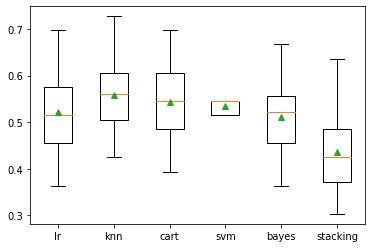

In [679]:
# compare ensemble to each baseline classifier
 
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model
 
# get a list of models to evaluate
def get_models():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models
 
# evaluate a give model using cross-validation on full dataset
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
# define dataset
X = data_set.drop('betterthanavg', axis = 1)
y = data_set['betterthanavg']

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

The accuracy of Stacking is 43.5%, nowhere near the accuracy of the base Decision Tree Classifier or the AdaBoosted Classifier. Thus we continue to try to improve the Adaboosted Decision Tree classifier


# HyperParameter tuning

Now let us try using Grid Search to understand what are the best hyperparameters to use for our decision tree classifier

In [680]:
tree_para = {'criterion':['gini','entropy'],'max_depth':[3,4,5,6,7,8,9,10,15,20, 30]}


clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
clf.fit(X, y)
clf.best_params_



{'criterion': 'gini', 'max_depth': 5}

Using the best parameters found, let us re run the decision tree classifier as well as the AdaBoost Classifier


In [681]:
model2 = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=1)
model2.fit(X_train, Y_train)
score = model2.score(X_test, Y_test)
print(f"Decision Tree Classifier's score: {score}")

Decision Tree Classifier's score: 0.5223880597014925


After using the optimum parameters, the accuracy of the Decision Tree Classifier increased from 50.9% to 52.2%


In [682]:
AdaBoost2 = AdaBoostClassifier(base_estimator=model2, n_estimators=400, learning_rate=1, random_state=1)

In [683]:
boostmodel2 = AdaBoost2.fit(X_train, Y_train)

#Evaluate the accuracy of the model
y_pred = boostmodel2.predict(X_test)
predictions = metrics.accuracy_score(Y_test, y_pred)
#Calculating the accuracy in percentage
print('The accuracy is: ', predictions * 100, '%')

The accuracy is:  56.71641791044776 %


After using the optimum parameters, the accuracy of the AdaBoosted Decision Tree Classifier did not change. 


# **Our final model accuracy is 56.7% accurate in predicting whether or not a player will play better than average in the next game**
